In [31]:
!pip install unidecode tokenizers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
import torch
import torch.nn as nn
import math

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tempfile

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Read Dataset

In [4]:
dataset_path = '/kaggle/input/aiomodule6financial-news-sentiment-analysis/dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(
    dataset_path,
    names=headers,
    encoding='ISO-8859-1'
)
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


### Text Normalisation - BPE

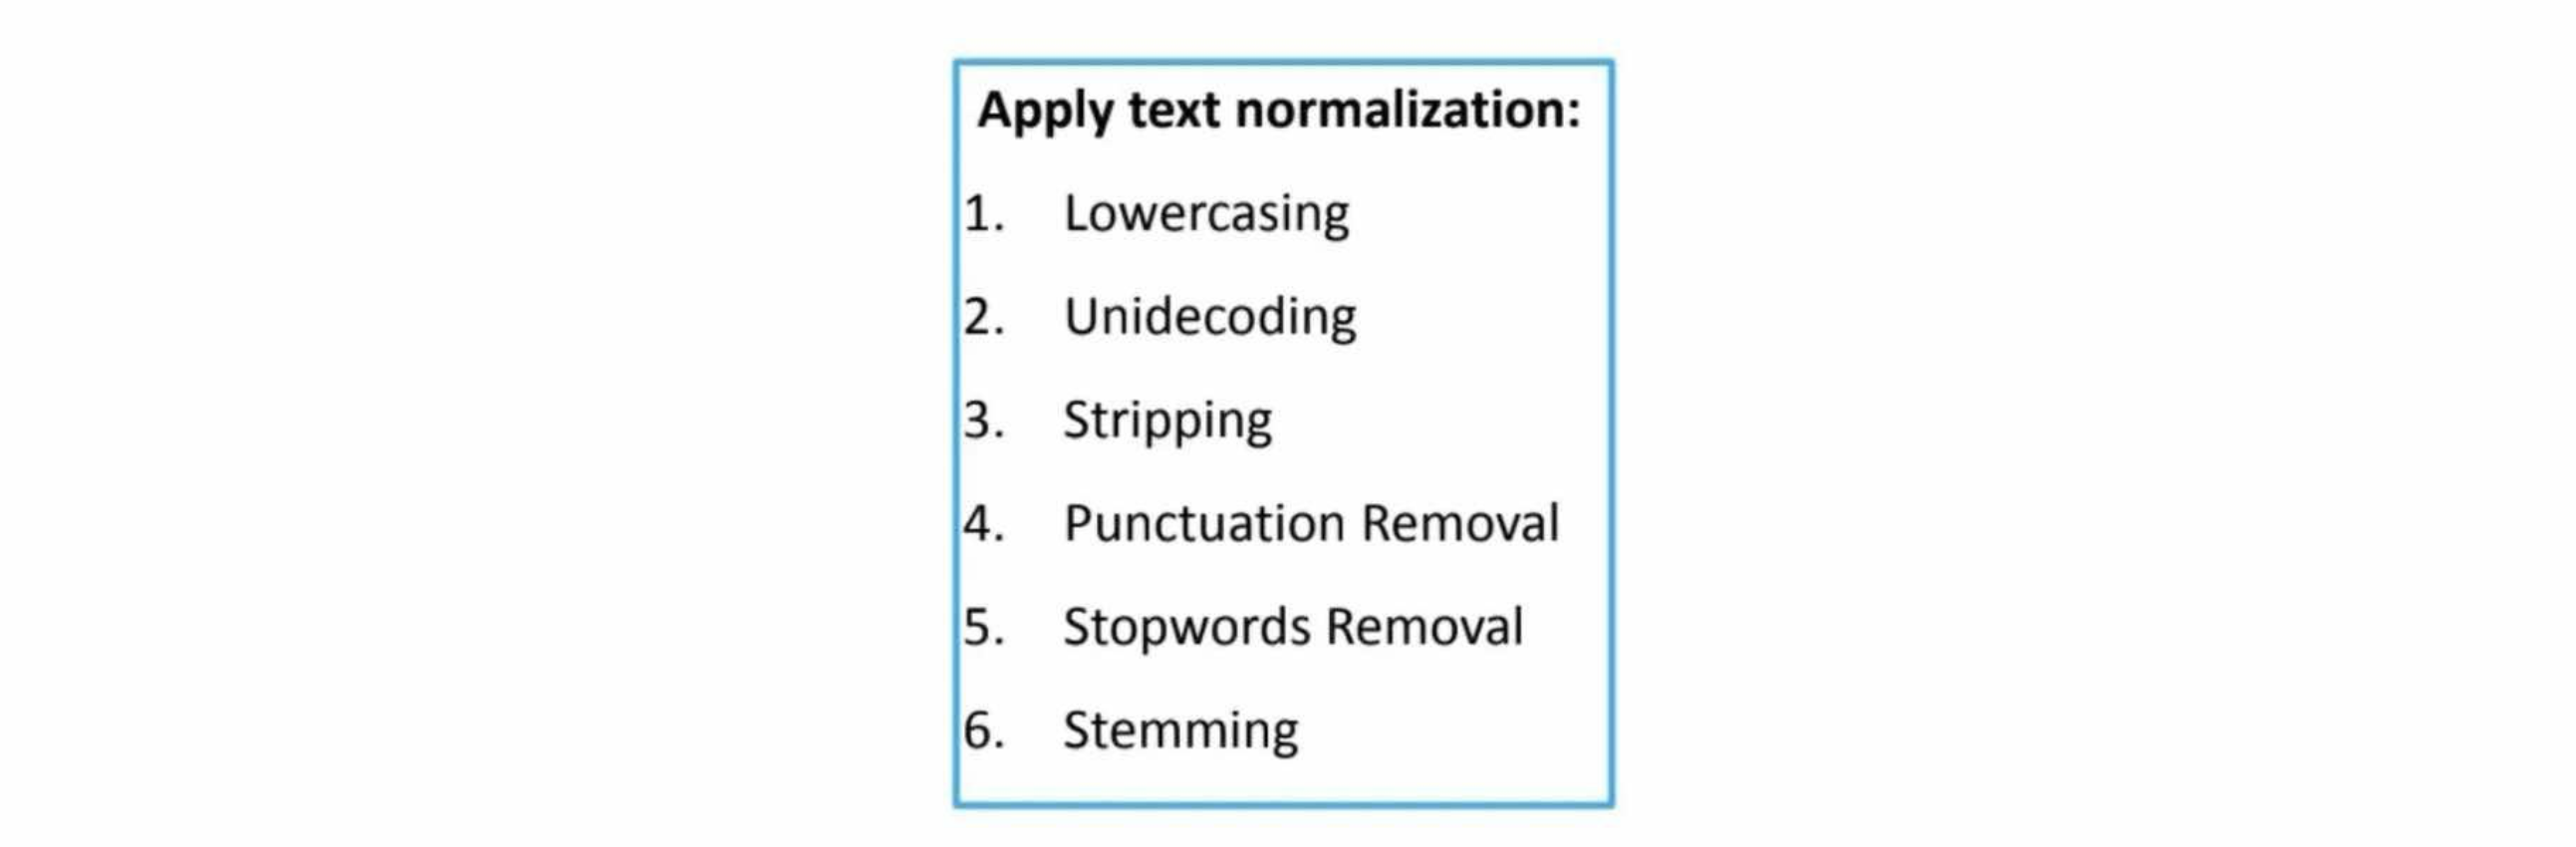

In [6]:
def text_normalize(text):
    text = text.lower() 
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text) # punctuation removal
    return text

In [7]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))
df['content'].head()

0    according to gran  the company has no plans to...
1    technopolis plans to develop in stages an area...
2    the international electronic industry company ...
3    with the new production plant the company woul...
4    according to the company s updated strategy fo...
Name: content, dtype: object

In [8]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
import tempfile
import os

# Write the text column to a temporary file
with tempfile.NamedTemporaryFile(mode='w+', delete=False) as tmp:
    for row in df['content']:
        tmp.write(row.strip() + '\n')
    tmp_path = tmp.name

# Initialize ByteLevel BPE tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

# Use ByteLevel pre-tokenizer
tokenizer.pre_tokenizer = ByteLevel()

# Use ByteLevel decoder
tokenizer.decoder = ByteLevelDecoder()

# Special tokens
special_tokens = ["[PAD]", "[UNK]"]

# Trainer
trainer = trainers.BpeTrainer(
    vocab_size=2000,
    special_tokens=special_tokens
)

# Train tokenizer
tokenizer.train([tmp_path], trainer)

# Clean up
os.remove(tmp_path)

# Padding
tokenizer.enable_padding(
    pad_token="[PAD]",
    pad_id=tokenizer.token_to_id("[PAD]"),
    length = None
)

# Encode
output = tokenizer.encode(text_normalize("Byte Pair Encoding is cool!"))
print("Tokens:", output.tokens)
print("IDs:", output.ids)




Tokens: ['Ġby', 'te', 'Ġpa', 'ir', 'Ġen', 'co', 'ding', 'Ġis', 'Ġco', 'ol']
IDs: [168, 813, 491, 142, 187, 1983, 153, 115, 205, 111]


### Split train, test

In [9]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

### Create Pytorch Dataset

In [10]:
import torch
from torch.utils.data import Dataset

class FinancialNews(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoded_text = self.tokenizer.encode(text)
        encoded_ids = torch.tensor(encoded_text.ids, dtype=torch.long)
        
        return encoded_ids, label

In [11]:
train_dataset = FinancialNews(
    X_train, 
    y_train,
    tokenizer
)

val_dataset = FinancialNews(
    X_val, 
    y_val,
    tokenizer
)

test_dataset = FinancialNews(
    X_test, 
    y_test,
    tokenizer
)

In [12]:
sample_id = 2

# Check 0-th sample and dataset length
text0, label0 = train_dataset[sample_id]
print(f"Train 0-th sample - text shape: {text0.shape}, label: {label0}")
print(f"Train dataset length: {len(train_dataset)}")

text0_val, label0_val = val_dataset[sample_id]
print(f"Val 0-th sample - text shape: {text0_val.shape}, label: {label0_val}")
print(f"Val dataset length: {len(val_dataset)}")

text0_test, label0_test = test_dataset[sample_id]
print(f"Test 0-th sample - text shape: {text0_test.shape}, label: {label0_test}")
print(f"Test dataset length: {len(test_dataset)}")


Train 0-th sample - text shape: torch.Size([55]), label: 2
Train dataset length: 3391
Val 0-th sample - text shape: torch.Size([16]), label: 1
Val dataset length: 970
Test 0-th sample - text shape: torch.Size([21]), label: 0
Test dataset length: 485


### Create DataLoader

In [13]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Separate data and labels
    encoded_ids, labels = zip(*batch)
    # Pad the sequences
    padded_sequences = pad_sequence(encoded_ids, batch_first=True, padding_value=tokenizer.token_to_id("[PAD]"))
    
    return padded_sequences, torch.tensor(labels, dtype = torch.long)

In [14]:
train_batch_size = 128
test_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn = collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    collate_fn = collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    collate_fn = collate_fn
)


In [15]:
for batch in train_loader:
    text, label = batch
    print(f"Train batch - text shape: {text.shape}, label shape: {label.shape}")
    break  # only check the first batch

for batch in val_loader:
    text, label = batch
    print(f"Validation batch - text shape: {text.shape}, label shape: {label.shape}")
    break

for batch in test_loader:
    text, label = batch
    print(f"Test batch - text shape: {text.shape}, label shape: {label.shape}")
    break

Train batch - text shape: torch.Size([128, 84]), label shape: torch.Size([128])
Validation batch - text shape: torch.Size([128, 81]), label shape: torch.Size([128])
Test batch - text shape: torch.Size([128, 98]), label shape: torch.Size([128])


### Model Construction

### Input Embeding

In [16]:
torch.arange(10).unsqueeze(1).float()

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [17]:
torch.exp(torch.arange(0, 10, 2).float() * -(math.log(10000.0) / 10))

tensor([1.0000e+00, 1.5849e-01, 2.5119e-02, 3.9811e-03, 6.3096e-04])

In [18]:
import torch
import torch.nn as nn
import math

class input_embeding(nn.Module):
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.word_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)
        self.dropout = nn.Dropout(0.5)

    def positional_encoding(self, seq_len, d_model, device):
        position = torch.arange(seq_len, device=device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() *
                             -(math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model, device=device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x):
        words_emb = self.word_emb(x)
        B, L, D = words_emb.shape
        device = x.device  # <- get device from input tensor
        positions_emb = self.positional_encoding(L, D, device)
        output = positions_emb + self.dropout(words_emb)
        return output

### Transformer Block


In [19]:
class transformer_layer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim = d_model, 
                                          num_heads = num_heads,
                                         batch_first = True)
        self.ffn1 = nn.Linear(in_features = d_model,
                             out_features = ff_dim)
        self.ffn2 = nn.Linear(in_features = ff_dim,
                             out_features = d_model)
        
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.5)

    def forward(self, Q, K, V):
        attn_output, _ = self.attn(Q, K, V)

        out1 = self.layer_norm_1(attn_output + Q)

        ffn_output = self.ffn2(self.dropout(self.leakyrelu(self.ffn1(out1))))

        out2 = self.layer_norm_2(out1 + ffn_output)

        return out2

### Tranformer Model

In [20]:
class tranformer_model(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, vocab_size, num_layers, num_classes):
        super().__init__()
        self.input_layer = input_embeding(d_model = d_model, 
                                          vocab_size = vocab_size)

        list_tranformer_layers = [
            transformer_layer(
                d_model = d_model, 
                num_heads = num_heads, 
                ff_dim = ff_dim
            ) for _ in range(num_layers)
        ]
        self.transformer_layers = nn.ModuleList(list_tranformer_layers)

        self.global_pooling = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        output = self.input_layer(x)
        for layer in self.transformer_layers:
            output = layer(output, output, output)
        output = self.global_pooling(output.transpose(1,2)).squeeze()
        output = self.classifier(output)

        return output

In [21]:
num_classes = len(list(classes.keys()))
d_model = 512
num_heads = 8 
ff_dim = 2048 
vocab_size = tokenizer.get_vocab_size()
num_layers = 1

# Before calling tranformer_model
print(f"Type of d_model: {type(d_model)}, value: {d_model}")
print(f"Type of num_heads: {type(num_heads)}, value: {num_heads}")
print(f"Type of ff_dim: {type(ff_dim)}, value: {ff_dim}")
print(f"Type of vocab_size: {type(vocab_size)}, value: {vocab_size}")
print(f"Type of num_layers: {type(num_layers)}, value: {num_layers}")
print(f"Type of num_classes: {type(num_classes)}, value: {num_classes}")


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = tranformer_model(
    d_model = d_model, 
    num_heads = num_heads, 
    ff_dim = ff_dim, 
    vocab_size = vocab_size, 
    num_layers = num_layers, 
    num_classes = num_classes
)

Type of d_model: <class 'int'>, value: 512
Type of num_heads: <class 'int'>, value: 8
Type of ff_dim: <class 'int'>, value: 2048
Type of vocab_size: <class 'int'>, value: 2000
Type of num_layers: <class 'int'>, value: 1
Type of num_classes: <class 'int'>, value: 3


In [22]:
input_x = torch.randint(0,2000, (1,100))
model(input_x)

tensor([-0.2059, -0.1305,  0.1993], grad_fn=<ViewBackward0>)

In [23]:
from torchinfo import summary
summary(model, input_size=(32,100), dtypes=[torch.int64], device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
tranformer_model                         [32, 3]                   --
├─input_embeding: 1-1                    [32, 100, 512]            --
│    └─Embedding: 2-1                    [32, 100, 512]            1,024,000
│    └─Dropout: 2-2                      [32, 100, 512]            --
├─ModuleList: 1-2                        --                        --
│    └─transformer_layer: 2-3            [32, 100, 512]            --
│    │    └─MultiheadAttention: 3-1      [32, 100, 512]            1,050,624
│    │    └─LayerNorm: 3-2               [32, 100, 512]            1,024
│    │    └─Linear: 3-3                  [32, 100, 2048]           1,050,624
│    │    └─LeakyReLU: 3-4               [32, 100, 2048]           --
│    │    └─Dropout: 3-5                 [32, 100, 2048]           --
│    │    └─Linear: 3-6                  [32, 100, 512]            1,049,088
│    │    └─LayerNorm: 3-7               [32, 100, 512

In [24]:
for batch in train_loader:
    text, label = batch
    print(model.to('cpu')(text).shape)
    break

torch.Size([128, 3])


In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
from typing import Literal, Optional
from torch.optim.lr_scheduler import StepLR, ExponentialLR
class training_model:
    def __init__(self, model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler: callable = None, metrics: dict[str, callable] = {"Accuracy": (accuracy_score, {})}, refit: str = "Accuracy"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = metrics
        self.refit = refit
        self.best_model_state = None
        self.scheduler = scheduler

    # Define train function
    def train_session(self):
        train_loss = 0
        total_samples = 0
        
        y_train_label_pred = []
        y_train_label_true = []

        metric_dict_train = {}

        # training session
        self.model.train()
        for X_train, y_train in self.train_loader:
            # X_train: (batch_size, in_channels, height, width)
            # y_train: (batch_size)

            y_train = y_train.to(device)
            X_train = X_train.to(device)
            
            self.optimizer.zero_grad() # reset optimizer gradients

            # forward pass
            output = self.model(X_train) # output: (batch_size, num_classes)

            # calculate loss
            loss = self.criterion(output, y_train)
            train_loss += loss.item() * len(y_train)
            total_samples += len(y_train)

            # Predictions
            y_train_label_true.extend(y_train.tolist())
            y_train_label_pred.extend(torch.argmax(output, dim=1).tolist())

            # calculate gradients
            loss.backward()

            # update weights
            self.optimizer.step()
        
        train_loss /= total_samples

        for metric_name, (metric_func, kwargs) in self.metrics.items():
            metric = metric_func(y_train_label_true, y_train_label_pred, **kwargs)
            metric_dict_train[metric_name] = metric

        return train_loss, metric_dict_train
    
    # Define validation (testing) function
    def eval_session(self, mode: Literal['Eval', 'Test'] = 'Eval'):
        # validation session
        self.model.eval()
        with torch.no_grad():
            if mode == "Eval":
                val_loss = 0
                total_samples = 0

                y_val_label_pred = []
                y_val_label_true = []

                metric_dict_val = {}
                for X_val, y_val in self.val_loader:
                    # X_val: (batch_size, in_channels, height, width)
                    # y_val: (batch_size)
    
                    y_val = y_val.to(device)
                    X_val = X_val.to(device)
                    
                    # forward pass
                    output = self.model(X_val) # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_val)
                    val_loss += loss.item() * len(y_val)
                    total_samples += len(y_val)
    
                    # Predictions
                    y_val_label_true.extend(y_val.tolist())
                    y_val_label_pred.extend(torch.argmax(output, dim=1).tolist())
            
                val_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_val_label_true, y_val_label_pred, **kwargs)
                    metric_dict_val[metric_name] = metric
        
                return val_loss, metric_dict_val
            elif mode == "Test":
                test_loss = 0
                total_samples = 0

                y_test_label_pred = []
                y_test_label_true = []

                metric_dict_test = {}
                for X_test, y_test in self.test_loader:
                    # X_test: (batch_size, in_channels, height, width)
                    # y_test: (batch_size)
    
                    y_test = y_test.to(device)
                    X_test = X_test.to(device)
                    
                    # forward pass
                    output = self.model(X_test) # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_test)
                    test_loss += loss.item() * len(y_test)
                    total_samples += len(y_test)
    
                    # Predictions
                    y_test_label_true.extend(y_test.tolist())
                    y_test_label_pred.extend(torch.argmax(output, dim=1).tolist())
            
                test_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_test_label_true, y_test_label_pred, **kwargs)
                    metric_dict_test[metric_name] = metric
        
                return test_loss, metric_dict_test
                

    def train(self, epochs):
        train_lossess = []
        val_lossess = []

        metric_dict_train_collect = {}
        metric_dict_val_collect = {}

        best_score = 0.0

        for epoch in range(epochs):
            score_collect_val = ''
            score_collect_train = ''
            
            train_loss, metric_dict_train = self.train_session()
            val_loss, metric_dict_val = self.eval_session()

            # save loss and accuracy
            train_lossess.append(train_loss)
            val_lossess.append(val_loss)

            for metric_name, metric_value in metric_dict_train.items():
                if metric_name not in metric_dict_train_collect:
                    metric_dict_train_collect[metric_name] = []
                metric_dict_train_collect[metric_name].append(metric_value)

                score_collect_train += f' - {metric_name}: {metric_value:.4f}'

            for metric_name, metric_value in metric_dict_val.items():
                if metric_name not in metric_dict_val_collect:
                    metric_dict_val_collect[metric_name] = []
                metric_dict_val_collect[metric_name].append(metric_value)

                score_collect_val += f' - {metric_name}: {metric_value:.4f}'

                if metric_name == self.refit:
                    # Save best model based on validation F1 score
                    if metric_value > best_score:
                        best_score = metric_value
                        self.best_model_state = self.model.state_dict()
                        print("=====================")
                        print(f"Epoch {epoch+1}: New best {metric_name} on val = {best_score:.4f}, saving model...") 
                        print("=====================")

            print("=====================")
            print(f"Epoch {epoch + 1} completed")
            print(f"Train Loss: {train_loss:.4f}" + score_collect_train)
            print(f"Val Loss: {val_loss:.4f}" + score_collect_val)
            print("=====================")
     
            if self.scheduler is not None:
                self.scheduler.step()
        return train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, self.best_model_state

    def test(self):
        best_model_state = self.best_model_state
        self.model.load_state_dict(best_model_state)

        score_collect = ''
        test_loss, metric_dict_test = self.eval_session(mode = "Test")
        
        for metric_name, metric_value in metric_dict_test.items():
            score_collect += f'- {metric_name}: {metric_value}'

        print(f'Test session - Test Loss: {test_loss} ' + score_collect)

In [27]:
num_classes = len(list(classes.keys()))
d_model = 128
num_heads = 4
ff_dim = 128
vocab_size = tokenizer.get_vocab_size()
num_layers = 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = tranformer_model(
    d_model = d_model, 
    num_heads = num_heads, 
    ff_dim = ff_dim, 
    vocab_size = vocab_size, 
    num_layers = num_layers, 
    num_classes = num_classes
).to(device)

epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [28]:
from sklearn.metrics import f1_score
training = training_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    optimizer = optimizer,
    # scheduler = scheduler,
    criterion = criterion,
    metrics = {"F1 Score": (f1_score, {"average": "macro"})},
    refit = "F1 Score"
)

train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, best_model_state = training.train(epochs)

Epoch 1: New best F1 Score on val = 0.3567, saving model...
Epoch 1 completed
Train Loss: 0.9882 - F1 Score: 0.3246
Val Loss: 0.8931 - F1 Score: 0.3567
Epoch 2: New best F1 Score on val = 0.4064, saving model...
Epoch 2 completed
Train Loss: 0.8677 - F1 Score: 0.3973
Val Loss: 0.8316 - F1 Score: 0.4064
Epoch 3: New best F1 Score on val = 0.4620, saving model...
Epoch 3 completed
Train Loss: 0.8308 - F1 Score: 0.4292
Val Loss: 0.8273 - F1 Score: 0.4620
Epoch 4: New best F1 Score on val = 0.4805, saving model...
Epoch 4 completed
Train Loss: 0.8070 - F1 Score: 0.4516
Val Loss: 0.8086 - F1 Score: 0.4805
Epoch 5: New best F1 Score on val = 0.4949, saving model...
Epoch 5 completed
Train Loss: 0.8044 - F1 Score: 0.4723
Val Loss: 0.7960 - F1 Score: 0.4949
Epoch 6: New best F1 Score on val = 0.5147, saving model...
Epoch 6 completed
Train Loss: 0.7780 - F1 Score: 0.5157
Val Loss: 0.7905 - F1 Score: 0.5147
Epoch 7: New best F1 Score on val = 0.5707, saving model...
Epoch 7 completed
Train Loss

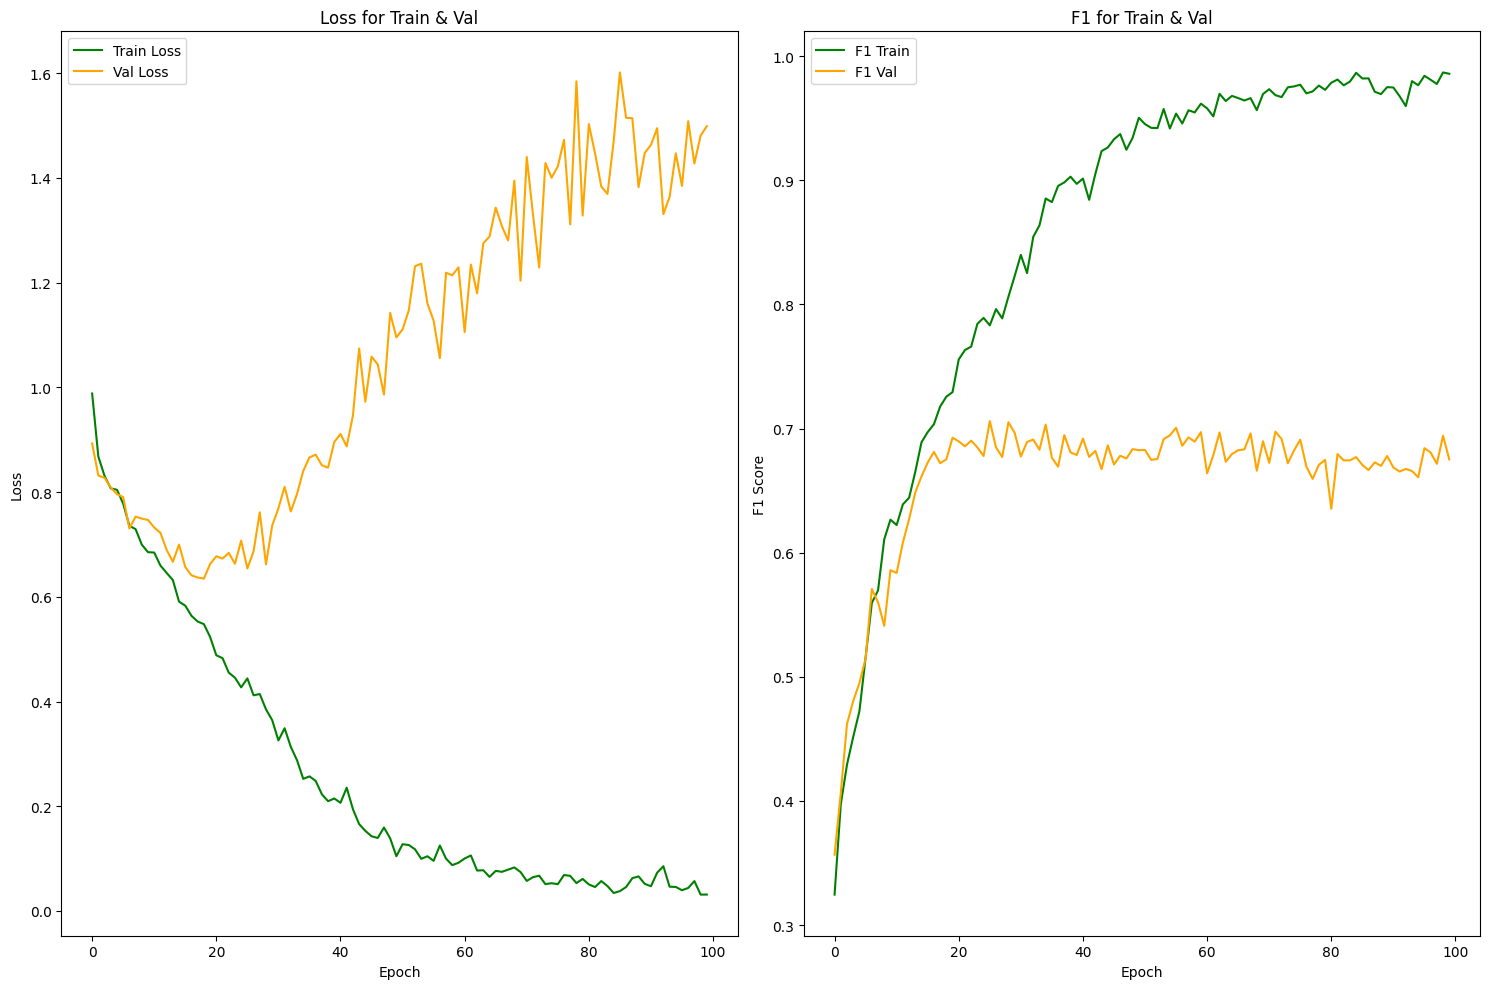

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].plot(train_lossess, color='green', label = 'Train Loss')
ax[0].plot(val_lossess, color='orange', label = 'Val Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Loss for Train & Val')
ax[0].legend()

ax[1].plot(metric_dict_train_collect['F1 Score'], color='green', label = 'F1 Train')
ax[1].plot(metric_dict_val_collect['F1 Score'], color='orange', label = 'F1 Val')
ax[1].set(xlabel='Epoch', ylabel='F1 Score')
ax[1].set_title('F1 for Train & Val')
ax[1].legend()

plt.tight_layout()

plt.show()

In [30]:
training.test()

Test session - Test Loss: 1.4660841091391967 - F1 Score: 0.6931568981700007
